In [66]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-o9dvr66h
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-o9dvr66h
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [67]:
import copy
import os
import sys
import time
from os import listdir
from os.path import isfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.models.segmentation import FCN_ResNet101_Weights, DeepLabV3_ResNet101_Weights, \
    DeepLabV3_MobileNet_V3_Large_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("\nSegmentation project running on", device)

# training parameters
train = True
in_size = (520, 520)
b_size = 32

lr = 1e-4
nb_epoch = 15

# model selection
model_choice = "dlab"
ft = True
appendix = "_ft" if ft else ""

if model_choice not in ["dlab", "dlab_large", "fcn"]:
    print("Error (wrong choice) : choose between dlab, dlab_large, or fcn")
    sys.exit(1)

In [69]:
class CocoDataset(Dataset):
    def __init__(self, root, subset, transform=None, sup=False):
        print(f"\nLoading {subset} dataset")

        self.imgs_dir = os.path.join(root + f"/{subset}2017/")

        ann_file = os.path.join("/kaggle/input/coco-2017-dataset/coco2017/annotations/", f"instances_{subset}2017.json")
        self.coco = COCO(ann_file)

        self.sup = sup
        self.classes = self.coco.loadCats(self.coco.getCatIds())

        self.class_names = [cat['name'] for cat in self.classes]
        self.superclasses = list(set([cat['supercategory'] for cat in self.classes]))

        self.target_classes = self.superclasses if self.sup else self.classes

        self.target_classes_nb = len(self.target_classes) + 1

        self.img_ids = self.coco.getImgIds()

        self.transform = transform

    def assign_class(self, normal_class, attrname):
        for c in self.classes:
            if c['id'] == normal_class:
                return c[attrname]

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        anns = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        img_obj = self.coco.loadImgs(img_id)[0]

        img = Image.open(os.path.join(self.imgs_dir, img_obj['file_name'])).convert('RGB')

        mask = np.zeros(img.size[::-1], dtype=np.uint8)

        for ann in anns:
            class_name = self.assign_class(ann['category_id'], 'name')
            pixel_value = self.class_names.index(class_name) + 1
            mask = np.maximum(self.coco.annToMask(ann) * pixel_value, mask)

        if self.sup:
            for cl in self.classes:
                idx = mask == cl['id']
                class_index = self.assign_class(cl['id'], 'supercategory')
                mask[idx] = self.superclasses.index(class_index) + 1

            idx = mask >= self.target_classes_nb
            mask[idx] = 0

        mask = Image.fromarray(mask)

        if self.transform is not None:
            img = self.transform(img)
            img = T.ToTensor()(img)
            img = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

            mask = self.transform(mask)
            mask = T.PILToTensor()(mask)

        return img, mask.long()

    def __len__(self):
        return len(self.img_ids)


class CocoTestDataset(Dataset):
    def __init__(self, root, subset, transform=None):
        print(f"\nLoading {subset} dataset")

        self.imgs_dir = os.path.join(root + "/test2017/")
        self.img_names = [f for f in listdir(self.imgs_dir) if isfile(os.path.join(self.imgs_dir, f))]
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.imgs_dir, self.img_names[idx])).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.img_names)


def get_data(input_size, batch_size=64, sup=False):
    data_transforms = {
        'train': T.Compose([
            T.Resize(input_size, interpolation=F.InterpolationMode.BILINEAR),
            T.CenterCrop(input_size)
        ]),
        'val': T.Compose([
            T.Resize(input_size, interpolation=F.InterpolationMode.BILINEAR),
            T.CenterCrop(input_size),
        ]),
        'test': T.Compose([
            T.Resize(input_size, interpolation=F.InterpolationMode.BILINEAR),
            T.CenterCrop(input_size),
            T.ToTensor()
        ]),
    }

    coco_train = CocoDataset(root="/kaggle/input/coco-2017-dataset/coco2017", subset="train",
                             transform=data_transforms["train"], sup=sup)
    train_dl = DataLoader(coco_train, batch_size=batch_size, shuffle=True)

    coco_val = CocoDataset(root="/kaggle/input/coco-2017-dataset/coco2017", subset="val",
                           transform=data_transforms["val"], sup=sup)
    val_dl = DataLoader(coco_val, batch_size=batch_size, shuffle=True)

    coco_test = CocoTestDataset(root="/kaggle/input/coco-2017-dataset/coco2017", subset="test",
                                transform=data_transforms["test"])
    test_dl = DataLoader(coco_test, batch_size=None, shuffle=True)

    cats = ['unlabeled'] + coco_train.target_classes

    return train_dl, val_dl, test_dl, cats


In [70]:
def decode_segmap(image, colormap, nc):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]

    rgb = np.stack([r, g, b], axis=2)

    return rgb


def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta = 0.75  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum

    image = np.array(image)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


def detect_classes(img, cats, nb_class):
    detected = []
    for lp in range(0, nb_class):
        idx = img == lp

        if idx.any():
            detected.append(lp)

    return [cats[cnb] for cnb in detected]


def segment_map(output, img, colormap, cats, nb_class):
    om = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

    cnames = detect_classes(om, cats, nb_class)

    segmented_image = decode_segmap(om, colormap, nb_class)

    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, om.shape, cv2.INTER_CUBIC)

    np_img = np.array(img * 255, dtype=np.uint8)

    overlayed_image = image_overlay(np_img, segmented_image)

    return segmented_image, overlayed_image, cnames


In [71]:
def load_model(choice="dlab", train=False, feat_extract=False, nb_class=1):
    print()

    if choice == "dlab":
        print(f"Model is {choice}")
        w = DeepLabV3_ResNet101_Weights.DEFAULT
        m = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, weights=w)

    elif choice == "dlab_large":
        print(f"Model is {choice}")
        w = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
        m = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=True, weights=w)
    elif choice == "fcn":
        print(f"Model is FCN")
        w = FCN_ResNet101_Weights.DEFAULT
        m = models.segmentation.fcn_resnet101(pretrained=True, progress=True, weights=w)
    else:
        return

    m.aux_classifier = None

    if train:
        m = create_trainable_dlab(m, nb_class)

    if feat_extract:
        for param in m.parameters():
            param.requires_grad = False

        for param in m.classifier.parameters():
            param.requires_grad = True

    params = [param for (name, param) in m.named_parameters() if param.requires_grad]

    return m, params


def create_trainable_dlab(model, nb_class):
    sample_input = torch.randn(1, 3, 32, 32)  # batch size 1, RGB input image of size 520x520
    backbone_output = model.backbone(sample_input)['out']  # get output of backbone module
    prev_channels = backbone_output.shape[1]
    model.classifier = DeepLabHead(prev_channels, nb_class)

    return model


def inference(model, dataloader, cats, nb_class, device, nbinf=5):
    model = model.eval()

    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(nb_class)])[:, None] * palette
    colormap = (colors % 255).numpy().astype("uint8")

    with torch.no_grad():
        for i, img in enumerate(dataloader):
            print("Iteration %d" % i)
            inp = img.unsqueeze(0).to(device)
            inp = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(inp)

            st = time.time()
            out = model.to(device)(inp)['out']
            end = time.time()

            print(f"Inference took: {end - st:.2f}", )

            f_img = img.permute(1, 2, 0)
            seg, overlay, cnames = segment_map(out, f_img, colormap, cats, nb_class)

            plot_results(f_img, seg, overlay, cnames)

            if i == nbinf:
                break


In [72]:
def plot_all(history):
    plot_metric(history, "acc")
    plot_metric(history, "loss")
    plot_metric(history, "score")


def plot_metric(data, lb):
    plt.plot(data[lb]['train'], label=f'train_{lb}', marker='o')
    plt.plot(data[lb]['val'], label=f'val_{lb}', marker='o')
    plt.title(f'{lb} per epoch')
    plt.ylabel(lb)
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


def plot_results(img, segmented_image, overlayed_image, cn):
    # Create the figure and subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 5), dpi=100)

    axs[0].axis("off")
    axs[0].set_title("Image")
    axs[0].imshow(img)

    axs[1].set_title("Segmentation")
    axs[1].axis("off")
    axs[1].imshow(segmented_image)

    axs[2].set_title("Overlayed")
    axs[2].axis("off")
    axs[2].imshow(overlayed_image)

    axs[3].set_title("Detected objects")
    axs[3].axis("off")
    axs[3].text(0, 0, '\n'.join(cn))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.show()


def get_classes(fpath):
    # Initialize dictionary
    label_dict = {}

    # Open file and read each line
    with open(fpath, 'r') as f:
        for line in f:
            line = line.strip()
            label_id, label_name = line.split(': ')

            label_dict[int(label_id)] = label_name

    return label_dict


In [77]:
def _fast_hist(label_true, label_pred, n_class):
    label_true = label_true.numpy()
    label_pred = label_pred.numpy()

    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist


def metrics_report(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    acc = np.diag(hist).sum() / hist.sum()

    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))

    valid = hist.sum(axis=1) > 0  # added

    mean_iu = np.nanmean(iu[valid])

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()

    cls_iu = dict(zip(range(n_class), iu))

    return {
        "pixel accuracy": acc,
        "mean accuracy": acc_cls,
        "frequency weighted IoU": fwavacc,
        "mean IoU": mean_iu,
        "class IoU": cls_iu,
    }


def pixel_accuracy(output, mask):
    correct = torch.eq(output, mask).int()

    accuracy = correct.sum(dim=(1, 2, 3)) / (mask.shape[2] * mask.shape[3])
    mean_accuracy = accuracy.mean()

    return mean_accuracy.item()


def mIoU(pred_mask, mask, n_classes, smooth=1e-10):
    pred_mask = pred_mask.view(-1)
    mask = mask.view(-1)

    iou_per_class = []
    for clas in range(n_classes):
        true_class = pred_mask == clas
        true_label = mask == clas

        intersect = (true_class & true_label).float().sum()
        union = (true_class | true_label).float().sum()

        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_val = (intersect + smooth) / (union + smooth)
            iou_per_class.append(iou_val.item())

    return np.nanmean(iou_per_class)


In [74]:
def train_model(model, dataloaders, criterion, optimizer, nb_class, device, epochs=15):
    model = model.to(device)

    since = time.time()

    train_acc_history = []
    train_loss_history = []
    train_score_history = []

    val_acc_history = []
    val_loss_history = []
    val_score_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0
            running_acc = 0
            running_miou = 0

            # Iterate over data.
            for images, masks in dataloaders[phase]:

                images = images.to(device)
                masks = masks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(images)['out']

                    loss = criterion(outputs, masks.squeeze(1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = torch.argmax(outputs, dim=1).unsqueeze(1).float()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_acc += pixel_accuracy(preds, masks)
                running_miou += mIoU(preds, masks, nb_class)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_acc / len(dataloaders[phase]) * 100
            epoch_miou = running_miou / len(dataloaders[phase]) * 100

            print('{} loss: {:.4f} acc: {:.2f}% mIoU {:.2f}%'.format(phase, epoch_loss, epoch_acc, epoch_miou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_score_history.append(epoch_miou)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_score_history.append(epoch_miou)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    metrics = {
        "acc": {"train": train_acc_history, "val": val_acc_history},
        "loss": {"train": train_loss_history, "val": val_loss_history},
        "score": {"train": train_score_history, "val": val_score_history}
    }

    return model, metrics

In [75]:
if train:
    train_ds, val_ds, test_ds, cats = get_data(input_size=in_size, batch_size=b_size, sup=True)
    nb_classes = len(cats)
    model, params_to_update = load_model(choice=model_choice, train=train, feat_extract=ft, nb_class=nb_classes)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adam(params_to_update, lr=lr)

    dls = {"train": train_ds, "val": val_ds}


Loading train dataset
loading annotations into memory...
Done (t=23.67s)
creating index...
index created!

Loading val dataset
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!

Loading test dataset

Model is dlab


In [79]:
if train:
    model, history = train_model(model, dls, criterion, optimizer, nb_classes, device, epochs=nb_epoch)

    torch.save(model, f"{model_choice}{appendix}.pt")

Epoch 1/3
--------------------
train loss: 1.3625 acc: 36.41% mIoU 11.22%
val loss: 3.6778 acc: 12.22% mIoU 5.68%
Epoch 2/3
--------------------
train loss: 1.2159 acc: 36.80% mIoU 11.19%
val loss: 3.3532 acc: 14.32% mIoU 6.11%
Epoch 3/3
--------------------
train loss: 0.9877 acc: 37.71% mIoU 11.80%
val loss: 2.9321 acc: 17.92% mIoU 8.93%

Training complete in 0m 7s
Best val accuracy: 17.921967


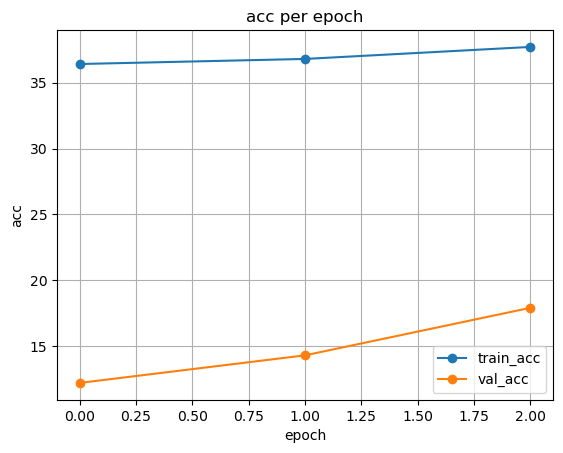

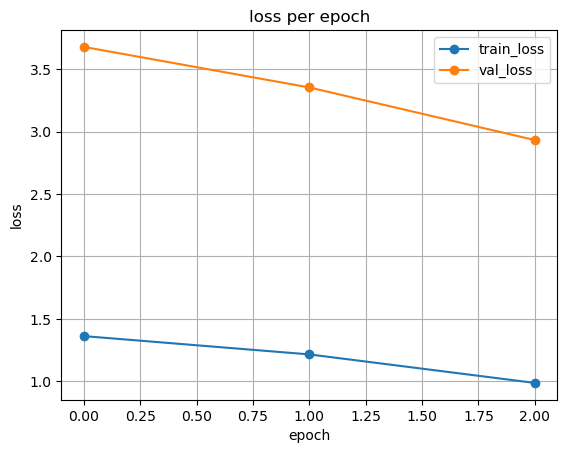

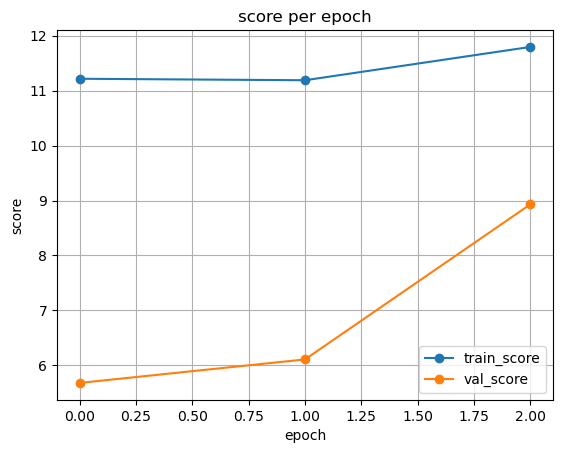

In [80]:
if train:
    plot_all(history)


Loading train dataset
loading annotations into memory...
Done (t=16.61s)
creating index...
index created!

Loading val dataset
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!

Loading test dataset
Model file found, using pretrained model for inference

Iteration 0
Inference took: 0.02


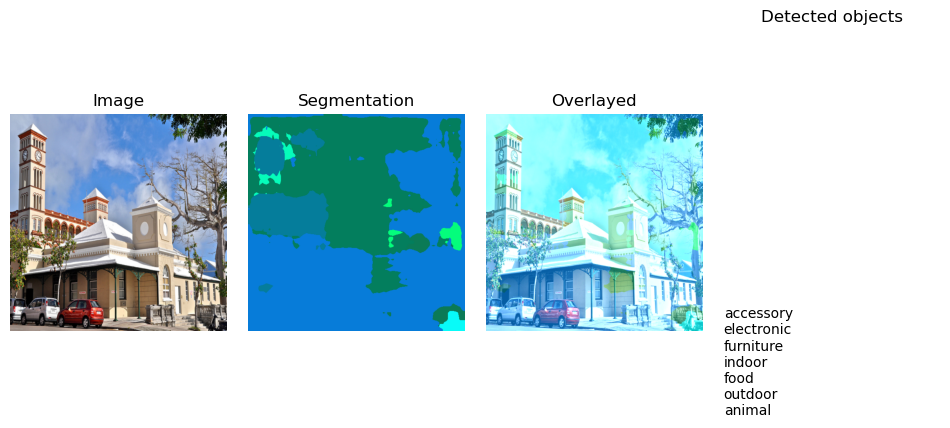

Iteration 1
Inference took: 0.02


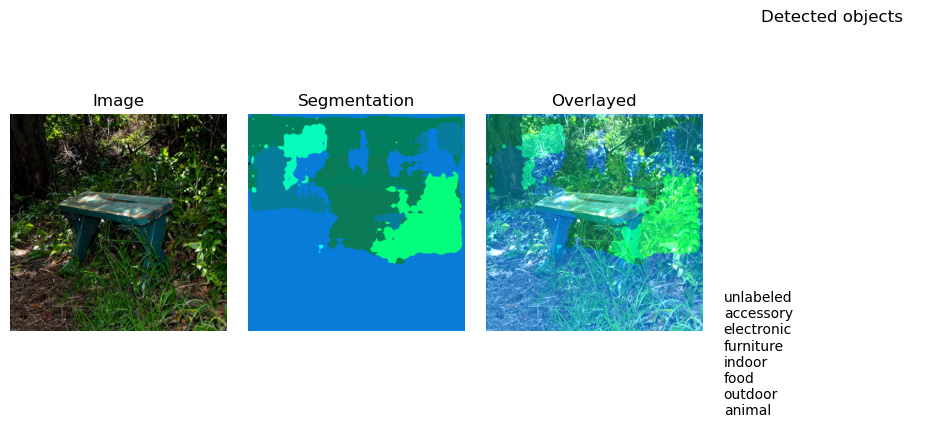

Iteration 2
Inference took: 0.02


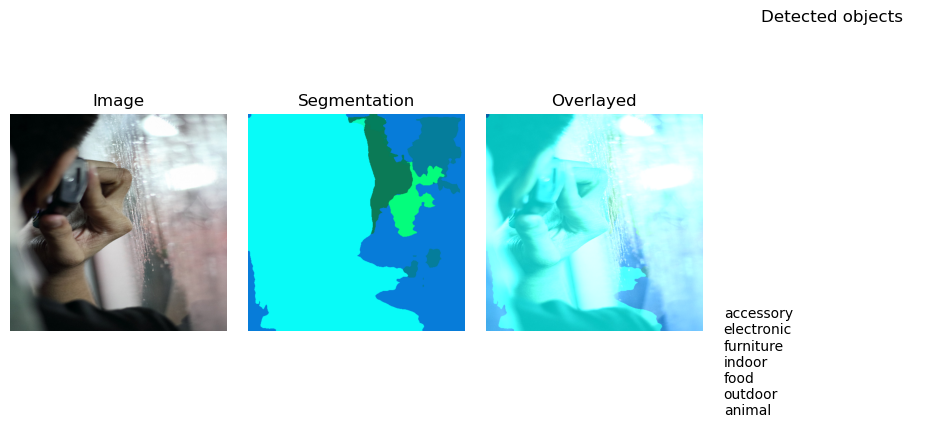

Iteration 3
Inference took: 0.02


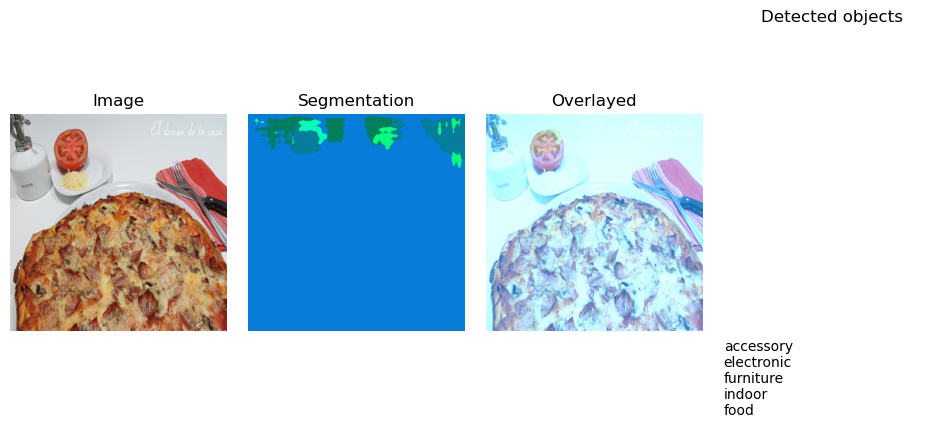

Iteration 4
Inference took: 0.02


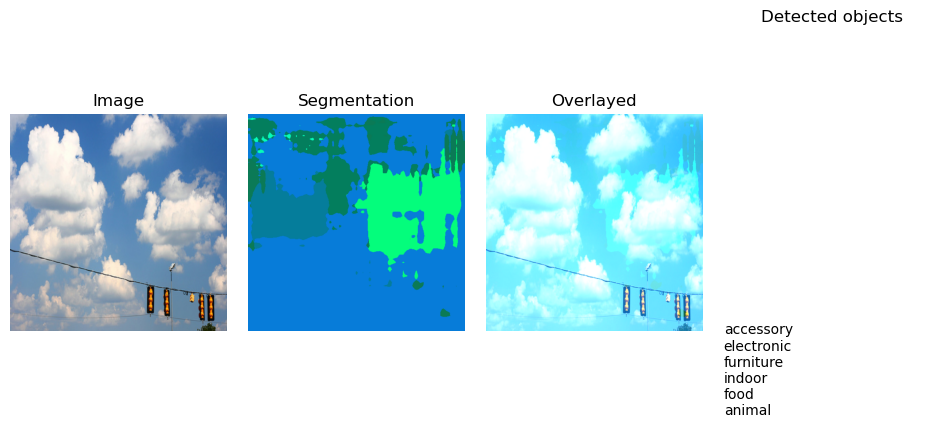

Iteration 5
Inference took: 0.02


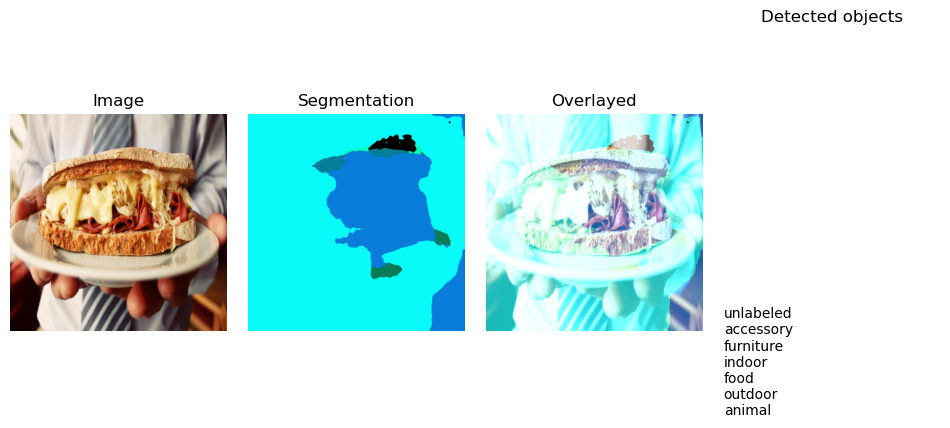

In [82]:
if True:

    _, _, test_ds, cats = get_data(input_size=in_size, batch_size=b_size, sup=True)

    # load trained model if available
    m_path = f"{model_choice}{appendix}.pt"

    if os.path.exists(m_path):
        print("Model file found, using pretrained model for inference\n")
        nb_classes = len(cats)
        model = torch.load(m_path)
    else:
        print("Model file not found, using Pytorch's model for inference\n")
        cats = get_classes("pascal.txt")
        nb_classes = len(cats)
        model, _ = load_model(choice=model_choice)

    inference(model, test_ds, cats, nb_classes, device, nbinf=5)

In [ ]:
print("\nEnd of the program")
